THE CODE BELOW INTEGRATES THE HW4 STUFF AND ADDS THE WORK FROM ABOVE...

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
import warnings

warnings.filterwarnings('ignore')
path = 'inputs/'
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 20)
pd.set_option('display.width', 500)
pd.set_option('display.expand_frame_repr', False)

In [2]:
def insert_holidays(testy):
    data = testy.copy()
    data['nat_holiday'] = 0
    data['reg_holiday'] = 0
    data['loc_holiday'] = 0

    stores = stores_new.copy()
    holidays = pd.read_csv(path + 'holidays_events.csv',
                        usecols=['date', 'type', 'locale', 'locale_name', 'transferred'],
                        dtype={'type': 'category', 'locale': 'category', 'locale_name': 'category', 'transferred': 'bool'},
                        parse_dates=['date'], infer_datetime_format=True
                        )
    holidays = holidays.reset_index()
    stores = stores.reset_index()

    for index, row in holidays.iterrows():
        store_nbr_list = []
        if row['locale'] == 'Local':
            for sindex, srow in stores.iterrows():
                if srow['city'] == row['locale_name']:
                    data.loc[(data['date'] == row['date']) & (data['store_nbr'] == srow['store_nbr']), 'loc_holiday'] = 1
        if row['locale'] == 'Regional':
            for sindex, srow in stores.iterrows():
                if srow['state'] == row['locale_name']:
                    data.loc[(data['date'] == row['date']) & (data['store_nbr'] == srow['store_nbr']), 'reg_holiday'] = 1
        if row['locale'] == 'National':
            data.loc[data['date'] == row['date'], 'nat_holiday'] = 1

    return data

In [3]:
data_oil = pd.read_csv(path + 'oil.csv', parse_dates=['date'], infer_datetime_format=True)
data_oil['dcoilwtico'].fillna(method='ffill', inplace=True)
data_oil['ma_oil'] = data_oil['dcoilwtico'].rolling(7).mean()
data_oil['ma_oil'].fillna(method='ffill', inplace=True)

In [4]:
# Create continguous moving average of oil prices
calendar = pd.DataFrame()
calendar['date'] = pd.date_range('2013-01-01', '2017-08-31')
cally = pd.merge(calendar, data_oil, how='outer', on='date' )
cally.fillna(method='ffill', inplace=True)
calendar = cally.copy()    #1704 rows

Import Stores Data

In [5]:
stores_new = pd.read_csv(path + 'stores.csv',
                         usecols=['store_nbr', 'city', 'state', 'type', 'cluster'],
                         dtype={'store_nbr': 'category', 'city': 'category', 'state': 'category', 'type': 'category', 'cluster': 'category'})

Import Transactions Data

In [6]:
transactions = pd.read_csv(path + 'transactions.csv',
                          usecols=['store_nbr', 'date', 'transactions'],
                          dtype={'store_nbr': 'category', 'transactions': 'float32'},
                          parse_dates=['date'], infer_datetime_format=True)
# transactions.date = transactions.date.dt.to_period('D')

In [7]:
df_train = pd.read_csv(path + 'train.csv',
                       usecols=['store_nbr', 'family', 'date', 'sales', 'onpromotion'],
                       dtype={'store_nbr': 'category', 'family': 'category', 'sales': 'float32', 'onpromotion': 'float32'},
                       parse_dates=['date'], infer_datetime_format=True)

Merge Training Data

In [8]:
df_train.date.nunique(), calendar.date.nunique()

(1684, 1704)

In [9]:
calendar.isnull().sum()

date          0
dcoilwtico    1
ma_oil        9
dtype: int64

In [10]:
df_train['date'].min(), df_train['date'].max()

(Timestamp('2013-01-01 00:00:00'), Timestamp('2017-08-15 00:00:00'))

In [11]:
calendar['date'].min(), calendar['date'].max()

(Timestamp('2013-01-01 00:00:00'), Timestamp('2017-08-31 00:00:00'))

In [12]:
train_oil = pd.merge(df_train, calendar, how='outer', on='date')

In [13]:
train_oil.sort_values(by=['family','store_nbr'], axis=0, inplace=True)
train_oil.isnull().sum()

date               0
store_nbr         20
family            20
sales             20
onpromotion       20
dcoilwtico      1782
ma_oil         16038
dtype: int64

In [14]:
train_oil['ma_oil'].fillna(method='ffill', inplace=True)
train_oil['dcoilwtico'].fillna(method='ffill', inplace=True)
train_oil.isnull().sum()

date            0
store_nbr      20
family         20
sales          20
onpromotion    20
dcoilwtico      1
ma_oil          9
dtype: int64

In [15]:
train_oil.tail(25)

,date,store_nbr,family,sales,onpromotion,dcoilwtico,ma_oil
2993759,2017-08-11,9,SEAFOOD,23.830999,0.0,48.81,49.140000
2995541,2017-08-12,9,SEAFOOD,16.859001,4.0,48.81,49.140000
2997323,2017-08-13,9,SEAFOOD,20.000000,0.0,48.81,49.140000
2999105,2017-08-14,9,SEAFOOD,17.000000,0.0,47.59,48.934286
3000887,2017-08-15,9,SEAFOOD,16.000000,0.0,47.57,48.648571
...,...,...,...,...,...,...,...
3000903,2017-08-27,NaN,NaN,NaN,NaN,47.65,47.720000
3000904,2017-08-28,NaN,NaN,NaN,NaN,46.40,47.624286
3000905,2017-08-29,NaN,NaN,NaN,NaN,46.46,47.320000
3000906,2017-08-30,NaN,NaN,NaN,NaN,45.96,47.115714


In [16]:
transactions.date.nunique(), train_oil.date.nunique()

(1682, 1704)

In [17]:
transactions['date'].min(), train_oil['date'].min()

(Timestamp('2013-01-01 00:00:00'), Timestamp('2013-01-01 00:00:00'))

In [18]:
transactions['date'].max(), train_oil['date'].max()

(Timestamp('2017-08-15 00:00:00'), Timestamp('2017-08-31 00:00:00'))

We had a lot of entries where the family value NaN - those definitely shouldn't be included

In [19]:
train_oil_trans = pd.merge(transactions, train_oil, how='outer', on =['store_nbr', 'date'])
train_oil_trans = train_oil_trans[train_oil_trans['family'].notna()]
# tmp.sort_values(by=['store_nbr', 'sales'], axis=0, inplace=True)
train_oil_trans[train_oil_trans['transactions'].isnull()]

,date,store_nbr,transactions,family,sales,onpromotion,dcoilwtico,ma_oil
2755104,2013-01-01,1,NaN,AUTOMOTIVE,0.0,0.0,NaN,NaN
2755105,2013-01-01,1,NaN,BABY CARE,0.0,0.0,47.57,48.648571
2755106,2013-01-01,1,NaN,BEAUTY,0.0,0.0,47.57,48.648571
2755107,2013-01-01,1,NaN,BEVERAGES,0.0,0.0,47.57,48.648571
2755108,2013-01-01,1,NaN,BOOKS,0.0,0.0,47.57,48.648571
...,...,...,...,...,...,...,...,...
3000883,2017-01-01,9,NaN,POULTRY,0.0,0.0,53.75,52.911429
3000884,2017-01-01,9,NaN,PREPARED FOODS,0.0,0.0,53.75,52.911429
3000885,2017-01-01,9,NaN,PRODUCE,0.0,0.0,53.75,52.911429
3000886,2017-01-01,9,NaN,SCHOOL AND OFFICE SUPPLIES,0.0,0.0,53.75,52.911429


Tons of days without any transactions -- let's look at this after we account for holidays

In [20]:
train_oil_trans_stores = train_oil_trans.merge(stores_new, on='store_nbr')
train_oil_trans_stores_holiday = insert_holidays(train_oil_trans_stores)
tmp = train_oil_trans_stores_holiday[train_oil_trans_stores_holiday.transactions.isnull()]
tmp = tmp.loc[(tmp.nat_holiday != 1) & (tmp.reg_holiday != 1) & (tmp.loc_holiday != 1)]
tmp

,date,store_nbr,transactions,family,sales,onpromotion,dcoilwtico,ma_oil,city,state,type,cluster,nat_holiday,reg_holiday,loc_holiday
53295,2014-03-24,25,NaN,AUTOMOTIVE,2.0,0.0,100.05,99.735714,Salinas,Santa Elena,D,1,0,0,0
53296,2014-03-24,25,NaN,BABY CARE,0.0,0.0,100.05,99.735714,Salinas,Santa Elena,D,1,0,0,0
53297,2014-03-24,25,NaN,BEAUTY,1.0,0.0,100.05,99.735714,Salinas,Santa Elena,D,1,0,0,0
53298,2014-03-24,25,NaN,BEVERAGES,2102.0,0.0,100.05,99.735714,Salinas,Santa Elena,D,1,0,0,0
53299,2014-03-24,25,NaN,BOOKS,0.0,0.0,100.05,99.735714,Salinas,Santa Elena,D,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3000883,2017-04-19,52,NaN,POULTRY,0.0,0.0,50.49,52.635714,Manta,Manabi,A,11,0,0,0
3000884,2017-04-19,52,NaN,PREPARED FOODS,0.0,0.0,50.49,52.635714,Manta,Manabi,A,11,0,0,0
3000885,2017-04-19,52,NaN,PRODUCE,0.0,0.0,50.49,52.635714,Manta,Manabi,A,11,0,0,0
3000886,2017-04-19,52,NaN,SCHOOL AND OFFICE SUPPLIES,0.0,0.0,50.49,52.635714,Manta,Manabi,A,11,0,0,0


In [21]:
# tmp.date.max(), tmp.date.min(), tmp.date.nunique()

In [22]:
# tmp.store_nbr.unique()

In [23]:
train_oil_trans_stores_holiday.transactions.fillna(0, inplace=True)
data = train_oil_trans_stores_holiday.copy()
# data_train['ma_oil'].fillna(method='ffill', inplace=True)
# data_train['date'] = pd.to_datetime(data_train['date'])
# data = data_train.copy()
# data['date'] = pd.to_datetime(data['date'])

In [24]:
# pd.to_datetime('2017-04-01') in data.date.unique()

In [25]:
del train_oil_trans_stores_holiday, train_oil_trans_stores, train_oil_trans, train_oil, data_oil, df_train, transactions, cally

In [26]:
data.sort_values(by=['store_nbr', 'family', 'date'], axis=0, inplace=True)
data.family.nunique()

33

In [27]:
#Adapted from https://www.kaggle.com/code/enesdilsiz/time-series-forecasting-with-lightgbm
def random_noise(dataframe):
    x = np.random.normal(scale=1.5, size=(len(dataframe),))
    return x


def lag_features(dataframe, lags):
    for lag in lags:
        dataframe['sales_lag_' + str(lag)] = dataframe.groupby(["store_nbr", "family"])['sales'].transform(
            lambda x: x.shift(lag)) + random_noise(dataframe)
    return dataframe

def roll_mean_features(dataframe, windows):
    for window in windows:
        dataframe['sales_roll_mean_' + str(window)] = dataframe.groupby(["store_nbr", "family"])['sales']. \
                                                          transform(
            lambda x: x.shift(1).rolling(window=window, min_periods=10, win_type="triang").mean()) + random_noise(
            dataframe)
    return dataframe

def ewm_features(dataframe, alphas, lags):
    for alpha in alphas:
        for lag in lags:
            dataframe['sales_ewm_alpha_' + str(alpha).replace(".", "") + "_lag_" + str(lag)] = \
                dataframe.groupby(["store_nbr", "family"])['sales'].transform(lambda x: x.shift(lag).ewm(alpha=alpha).mean())
    return dataframe

In [28]:
df = data.copy()
df['year'] = df.date.dt.year
df['month'] = df.date.dt.month
df['quarter_of_year'] = df.date.dt.quarter
df['week_of_year'] = df.date.dt.isocalendar().week
df['day_of_year'] = df.date.dt.dayofyear
df['day_of_month'] = df.date.dt.day
df['day_of_week'] = df.date.dt.dayofweek
df["is_wknd"] = df.date.dt.weekday // 4
df['is_month_start'] = df.date.dt.is_month_start.astype(int)
df['is_month_end'] = df.date.dt.is_month_end.astype(int)
 # pd.DataFrame({"sales": df["sales"].values[0:10],
 #              "lag1": df["sales"].shift(1).values[0:10],
 #              "lag2": df["sales"].shift(2).values[0:10],
 #              "lag3": df["sales"].shift(3).values[0:10],
 #              "lag4": df["sales"].shift(4).values[0:10]})

In [29]:
# df.groupby(["store_nbr", "family"]).head()

In [30]:
lags = [x for x in range(16, 121, 7)]
alphas = [0.95, 0.9, 0.8, 0.7, 0.5]

In [31]:
df = lag_features(df, lags)

In [32]:
df = roll_mean_features(df, [128, 365, 546])

In [33]:
df = ewm_features(df, alphas, lags)

In [34]:
df = pd.get_dummies(df, columns=['store_nbr', 'family', 'day_of_week', 'month'])

In [35]:
df = pd.get_dummies(df, columns=['city', 'state'])

In [36]:
# df.date.min(), df.date.max()

In [37]:
# df.tail(20)

In [38]:
df.drop('week_of_year', axis=1, inplace=True)

In [39]:
import re
df = df.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

In [40]:

train = df.loc[(df.date < "2013-07-15"), :]
val = df.loc[(df.date >= "2013-07-15" ) & (df.date < "2017-07-31")]

cols = [col for col in train.columns if col not in ['date', 'sales', 'year']]

Y_train = train['sales']
X_train = train[cols]

Y_val = val['sales']
X_val = val[cols]

Y_train.shape, X_train.shape, Y_val.shape, X_val.shape

((347490,), (347490, 252), (2624886,), (2624886, 252))

In [41]:
lgb_params = {'num_leaves': 10,
              'learning_rate': 0.02,
              'feature_fraction': 0.8,
              'max_depth': 5,
              'verbose': 0,
              'num_boost_round': 10000,
              'early_stopping_rounds': 200,
              'nthread': -1}

In [42]:
lgbtrain = lgb.Dataset(data=X_train, label=Y_train, feature_name=cols)

lgbval = lgb.Dataset(data=X_val, label=Y_val, reference=lgbtrain, feature_name=cols)

Load Test Data

In [43]:
df_test = pd.read_csv(path + 'test.csv',
                      usecols=['store_nbr', 'family', 'date', 'onpromotion'],
                      dtype={'store_nbr': 'category', 'family': 'category', 'onpromotion': 'float32'},
                      parse_dates=['date'], infer_datetime_format=True)
test_stores = df_test.merge(stores_new, on='store_nbr')
test_stores_cal = test_stores.merge(calendar, on='date')
data_test = insert_holidays(test_stores_cal)

LightGBM -- Setup

In [44]:
def smape(preds, target):
    n = len(preds)
    masked_arr = ~((preds == 0) & (target == 0))
    preds, target = preds[masked_arr], target[masked_arr]
    num = np.abs(preds - target)
    denom = np.abs(preds) + np.abs(target)
    smape_val = (200 * np.sum(num / denom)) / n
    return smape_val


def lgbm_smape(preds, train_data):
    labels = train_data.get_label()
    smape_val = smape(preds, labels)
    return 'SMAPE', smape_val, False

In [45]:
import pickle

model = lgb.train(lgb_params, lgbtrain,
                  valid_sets=[lgbtrain, lgbval],
                  num_boost_round=lgb_params['num_boost_round'],
                  callbacks=[lgb.early_stopping(stopping_rounds=200)],
                  feval=lgbm_smape,
                  verbose_eval=100)

pickle.dump(model, open("models/smape_lgbm.dat",'wb'))

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.030615 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds
[100]	training's l2: 46383.7	training's SMAPE: 134.019	valid_1's l2: 242496	valid_1's SMAPE: 108.687
[200]	training's l2: 26181.7	training's SMAPE: 125.162	valid_1's l2: 188686	valid_1's SMAPE: 91.5694
[300]	training's l2: 21265.1	training's SMAPE: 123.05	valid_1's l2: 178205	valid_1's SMAPE: 105.655
[400]	training's l2: 18961.5	training's SMAPE: 123.785	valid_1's l2: 174166	valid_1's SMAPE: 111.624
Early stopping, best iteration is:
[239]	training's l2: 23624.5	training's SMAPE: 123.03	valid_1's l2: 182834	valid_1's SMAPE: 89.111


In [46]:
y_pred_val = model.predict(X_val, num_iteration=model.best_iteration)

In [47]:
smape(y_pred_val, Y_val)

89.1110463771732

In [48]:
def plot_lgb_importances(model, plot=False, num=10):
    gain = model.feature_importance('gain')
    feat_imp = pd.DataFrame({'feature': model.feature_name(),
                             'split': model.feature_importance('split'),
                             'gain': 100 * gain / gain.sum()}).sort_values('gain', ascending=False)
    if plot:
        plt.figure(figsize=(10, 10))
        sns.set(font_scale=1)
        sns.barplot(x="gain", y="feature", data=feat_imp[0:25])
        plt.title('feature')
        plt.tight_layout()
        plt.show(block=True)
    else:
        print(feat_imp.head(num))
    return feat_imp

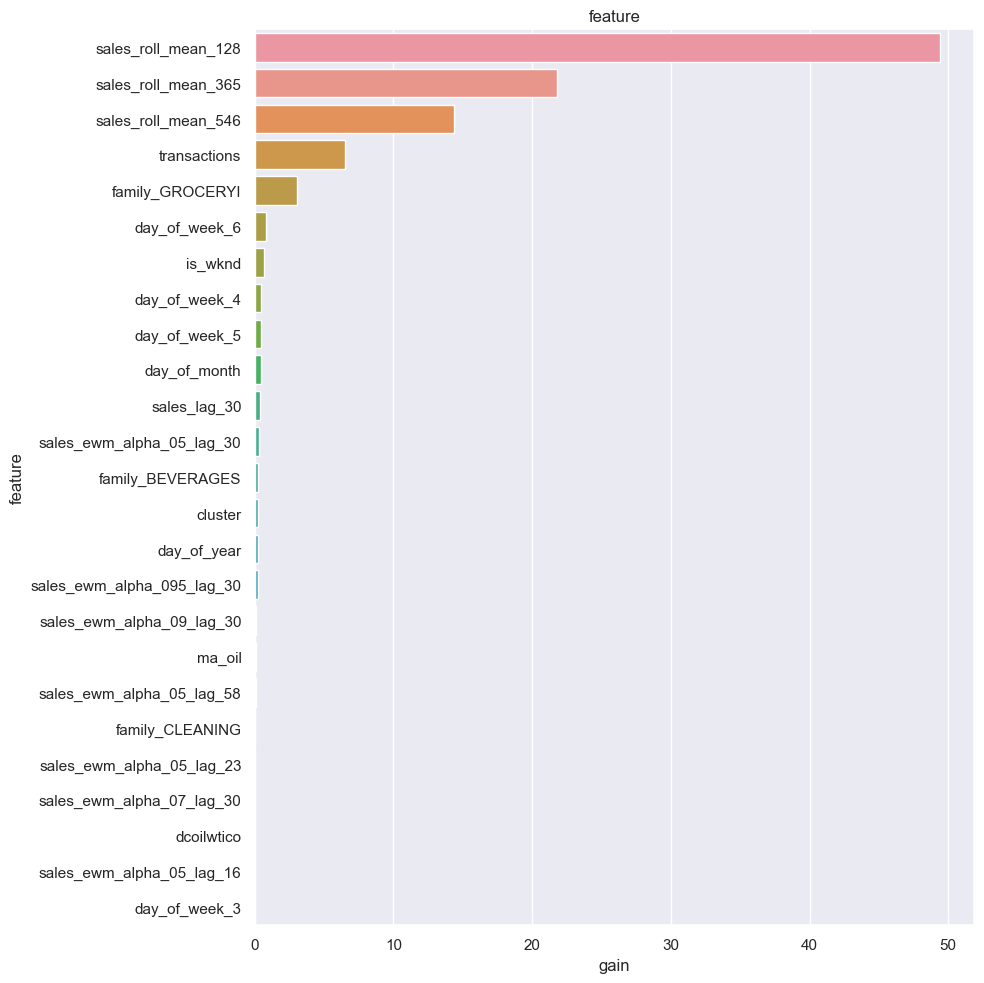

,feature,split,gain
30,sales_roll_mean_128,371,49.386745
31,sales_roll_mean_365,165,21.781212
32,sales_roll_mean_546,104,14.388233
0,transactions,440,6.501831
174,family_GROCERYI,142,3.034893
...,...,...,...
111,store_nbr_12,0,0.000000
112,store_nbr_13,0,0.000000
113,store_nbr_14,0,0.000000
114,store_nbr_15,0,0.000000


In [49]:
plot_lgb_importances(model, num=30, plot=True)

In [50]:
feat_imp = plot_lgb_importances(model, num=200)

low_importance = feat_imp[feat_imp["gain"] <= 0.005]["feature"].values

dff = df.drop(low_importance, axis=1)

cols_dff = [col for col in dff.columns if col not in ['date', "sales", "year"]]

                         feature  split       gain
30           sales_roll_mean_128    371  49.386745
31           sales_roll_mean_365    165  21.781212
32           sales_roll_mean_546    104  14.388233
0                   transactions    440   6.501831
174              family_GROCERYI    142   3.034893
..                           ...    ...        ...
45   sales_ewm_alpha_095_lag_100      0   0.000000
47   sales_ewm_alpha_095_lag_114      0   0.000000
48     sales_ewm_alpha_09_lag_16      0   0.000000
81     sales_ewm_alpha_07_lag_37      0   0.000000
83     sales_ewm_alpha_07_lag_51      0   0.000000

[200 rows x 3 columns]


In [51]:
train = dff.loc[~df.sales.isna()]
Y_train = train['sales']
X_train = train[cols_dff]


test = dff.loc[df.date >= "2017-07-31"]
X_test = test[cols_dff]
X_test.sales = np.nan

In [52]:
def rmsle_lgbm(y_pred, data):

    y_true = np.array(data.get_label())
    score = np.sqrt(np.mean(np.power(np.log1p(y_true) - np.log1p(y_pred), 2)))

    return 'rmsle', score, False

In [53]:
lgb_params = {'num_leaves': 10,
              'learning_rate': 0.02,
              'feature_fraction': 0.8,
              'max_depth': 5,
              'verbose': 0,
              'nthread': -1,
              "num_boost_round": model.best_iteration}

In [54]:
lgbtrain_all = lgb.Dataset(data=X_train, label=Y_train, feature_name=cols_dff)

In [55]:
final_model = lgb.train(lgb_params, lgbtrain_all, num_boost_round=model.best_iteration)

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.089222 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.


In [56]:
test_preds = final_model.predict(X_test, num_iteration=model.best_iteration)

In [57]:
test_preds

array([18.58985608, 18.58985608, 18.58985608, ..., 29.85813465,
       24.12029154, 24.12029154])